In [1]:
# this file takes in all files and produce the appropriate d2s analysis
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt

In [2]:
# I prefer these LaTeX plots to fit in with the paper better
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
dspl_html = lambda x: display_html(x, raw=True)
rouge = load('rouge')

In [4]:
root_path = Path("/home/vente/repos/nlgs-research")
pkl = list((root_path / "pipeline/predictions").glob("*d2s*"))[0]
pkl.name

'd2s-t5-small-5.pkl'

In [5]:
OUTPUT_PATH = root_path / "pipeline/scores" / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/d2s-t5-small-5')

In [6]:
test_predictions = pd.read_pickle(pkl)

In [7]:
compute_rouge = lambda x,y: rouge.compute(references=[x], predictions=[y], use_stemmer=False, use_aggregator=False)
compute_rouge(["general kenobi"], "general kenobi")
y_pred = test_predictions.drop(columns=['input_ids','attention_mask','pred_ids','labels'])

chunked = (
  seq(y_pred.to_dict('records'))
    .group_by(get.record_idx)
    .map(get[1]) # focus on teh values
    .map(lambda x: [
      seq(x).map(get.nl).to_list(),        # gather up all of the references
      seq(x).map(get.decoded).to_list()[0] # and the first prediction
    ])
)
chunked

"['Abilene, Texas is served by the Abilene regional airport.', 'Abilene Regional Airport serves the city of Abilene in Texas.']","Abilene Regional Airport serves the city of Abilene, Texas."
"['Adolfo Suarez Madrid-Barajas Airport can be found in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.', 'Adolfo Suarez Madrid-Barajas airport is located at Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.', 'Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.']","Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas."
"['The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.', 'The runway name at Adolfo Suarez Madrid-Barajas airport is 18L/36R.', 'The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.']",The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.
"['Afonso Pena International Airport ICAO Location Idenitifier is SBCT.', 'SBCT is the ICAO location identifier of Afonso Pena International Airport.']",The ICAO location identifier of Afonso Pena International Airport is SBCT.
"['Afonso Pena International Airport serves the city of Curitiba.', 'Afonso Pena International Airport serves Curitiba.']",Afonso Pena International Airport serves the city of Curitiba.
"['The Al Taqaddum Air Base serves the city of Fallujah.', 'Al-Taqaddum Air Base serves the city of Fallujah.']",Al-Taqaddum Air Base serves the city of Falujah.
"['The runway length of Al-Taqaddum Air Base is 3684.0.', 'The length of the runway at Al-Taqaddum Air Base is 3684.0.']",The runway length of Al-Taqaddum Air Base is 3684.0.
"['Alderney Airport runway name is 14/32.', '14/32 is the runway name of Alderney Airport.', 'The runway name of Alderney Airport is 14/32.']",The runway name of Alderney Airport is 14/32.
"['The runway length at Allama Iqbal International Airport is 3,360.12.', 'The runway at Allama Iqbal International Airport has a length of 3360.12.', 'The runway at Allama Iqbal International Airport is 3360.12 long.']",The runway length of Allama Iqbal International Airport is 3360.12.
"[""The first runway at Amsterdam's Schiphol Airport is known as Number 18."", ""The Amsterdam Airport Schiphol's 1st runway number is 18."", 'The number of the 1st runway at Amsterdam Airport Schiphol is 18.']",The 1st runway number at Amsterdam Airport Schiphol is 18.


In [8]:
rouge_scores = (
  chunked.starmap(compute_rouge)
    # only one rouge per sample, so take the first of the values
    .map(lambda x: seq(x.items()).starmap(lambda x,y : {x:y[0]}))
    # rolling union on dictionaries since they are disjoint
    .map(lambda x: seq(x).reduce(lambda x, y: x | y))
    .to_pandas()
)
rouge_scores

,rouge1,rouge2,rougeL,rougeLsum
0,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000
3,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
1595,0.888889,0.693878,0.646465,0.646465
1596,0.650000,0.379747,0.493827,0.493827
1597,0.896552,0.776471,0.827586,0.827586
1598,0.800000,0.574713,0.700000,0.700000


In [9]:
rouge_scores.describe()

,rouge1,rouge2,rougeL,rougeLsum
count,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.848860,0.672264,0.745394,0.745394
std,0.110731,0.200575,0.177137,0.177137
min,0.387097,0.125000,0.266667,0.266667
25%,0.780488,0.533333,0.612245,0.612245
50%,0.851064,0.666667,0.750000,0.750000
75%,0.933871,0.800000,0.894737,0.894737
max,1.000000,1.000000,1.000000,1.000000


In [10]:
bleu = load('sacrebleu')
bleu
compute_bleu = lambda x,y: bleu.compute(references=[x], predictions=[y],lowercase=True, tokenize='intl')

In [11]:
bleu_scores = (
  chunked.starmap(compute_bleu)
    .to_pandas()
)

In [12]:
bleu_scores

,score,counts,totals,precisions,bp,sys_len,ref_len
0,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11
1,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23
2,100.000000,"[15, 14, 13, 12]","[15, 14, 13, 12]","[100.0, 100.0, 100.0, 100.0]",1.000000,15,15
3,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666...",1.000000,12,12
4,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10
...,...,...,...,...,...,...,...
1595,82.699805,"[53, 48, 43, 35]","[55, 54, 53, 52]","[96.36363636363636, 88.88888888888889, 81.1320...",1.000000,55,54
1596,31.277816,"[32, 21, 14, 10]","[40, 39, 38, 37]","[80.0, 53.84615384615385, 36.8421052631579, 27...",0.687289,40,55
1597,79.156875,"[46, 40, 35, 31]","[49, 48, 47, 46]","[93.87755102040816, 83.33333333333333, 74.4680...",1.000000,49,49
1598,55.721120,"[50, 37, 26, 19]","[57, 56, 55, 54]","[87.71929824561404, 66.07142857142857, 47.2727...",1.000000,57,56


In [13]:
bertscore = load('bertscore')
compute_bert = lambda x,y: bertscore.compute(predictions=[y], references=[x], lang="en", model_type="distilbert-base-uncased" )

In [14]:
bert_scores = (
 chunked
   .starmap(compute_bert)
   .to_pandas()
   .drop(columns='hashcode')
   .applymap(np.mean)
)

In [15]:
prepend_name_to_cols = lambda x,y : x.rename(columns=lambda e: y+"_"+e)
prepend_name_to_cols(bert_scores, 'bert')
all_scores = (
  seq(bert_scores, bleu_scores, rouge_scores)
    .zip(['bert','bleu','rouge'])
    .starmap(prepend_name_to_cols)
)
unflt = pd.DataFrame(chunked, columns=['references','predictions'])
scores_df = pd.concat(all_scores, axis=1)
scores_df

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,100.000000,"[15, 14, 13, 12]","[15, 14, 13, 12]","[100.0, 100.0, 100.0, 100.0]",1.000000,15,15,1.000000,1.000000,1.000000,1.000000
3,0.967089,0.967089,0.967089,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666...",1.000000,12,12,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.936552,0.932994,0.933446,82.699805,"[53, 48, 43, 35]","[55, 54, 53, 52]","[96.36363636363636, 88.88888888888889, 81.1320...",1.000000,55,54,0.888889,0.693878,0.646465,0.646465
1596,0.926603,0.883873,0.904734,31.277816,"[32, 21, 14, 10]","[40, 39, 38, 37]","[80.0, 53.84615384615385, 36.8421052631579, 27...",0.687289,40,55,0.650000,0.379747,0.493827,0.493827
1597,0.981708,0.983372,0.982539,79.156875,"[46, 40, 35, 31]","[49, 48, 47, 46]","[93.87755102040816, 83.33333333333333, 74.4680...",1.000000,49,49,0.896552,0.776471,0.827586,0.827586
1598,0.936510,0.950141,0.933748,55.721120,"[50, 37, 26, 19]","[57, 56, 55, 54]","[87.71929824561404, 66.07142857142857, 47.2727...",1.000000,57,56,0.800000,0.574713,0.700000,0.700000


In [16]:
scores_preds = pd.concat([scores_df,unflt], axis=1)
scores_preds 

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum,references,predictions
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368,"[Abilene, Texas is served by the Abilene regio...",Abilene Regional Airport serves the city of Ab...
1,1.000000,1.000000,1.000000,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23,1.000000,1.000000,1.000000,1.000000,[Adolfo Suarez Madrid-Barajas Airport can be f...,Adolfo Suarez Madrid-Barajas Airport is locate...
2,1.000000,1.000000,1.000000,100.000000,"[15, 14, 13, 12]","[15, 14, 13, 12]","[100.0, 100.0, 100.0, 100.0]",1.000000,15,15,1.000000,1.000000,1.000000,1.000000,[The runway name of Adolfo Suarez Madrid-Baraj...,The runway name of Adolfo Suarez Madrid-Baraja...
3,0.967089,0.967089,0.967089,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666...",1.000000,12,12,1.000000,0.800000,0.818182,0.818182,[Afonso Pena International Airport ICAO Locati...,The ICAO location identifier of Afonso Pena In...
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000,[Afonso Pena International Airport serves the ...,Afonso Pena International Airport serves the c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.936552,0.932994,0.933446,82.699805,"[53, 48, 43, 35]","[55, 54, 53, 52]","[96.36363636363636, 88.88888888888889, 81.1320...",1.000000,55,54,0.888889,0.693878,0.646465,0.646465,[The Acharya Institute of Technology in Karnat...,The Acharya Institute of Technology is located...
1596,0.926603,0.883873,0.904734,31.277816,"[32, 21, 14, 10]","[40, 39, 38, 37]","[80.0, 53.84615384615385, 36.8421052631579, 27...",0.687289,40,55,0.650000,0.379747,0.493827,0.493827,[The Germans of Romania are one of the ethnic ...,The 1 Decembrie 1918 University is located in ...
1597,0.981708,0.983372,0.982539,79.156875,"[46, 40, 35, 31]","[49, 48, 47, 46]","[93.87755102040816, 83.33333333333333, 74.4680...",1.000000,49,49,0.896552,0.776471,0.827586,0.827586,[The School of Business and Social Sciences at...,The School of Business and Social Sciences at ...
1598,0.936510,0.950141,0.933748,55.721120,"[50, 37, 26, 19]","[57, 56, 55, 54]","[87.71929824561404, 66.07142857142857, 47.2727...",1.000000,57,56,0.800000,0.574713,0.700000,0.700000,[Denmark is led by the Monarchy of Demark and ...,The School of Business and Social Sciences at ...


In [17]:
scores_df.describe()

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.956341,0.950560,0.952563,64.120532,0.962366,22.014375,22.225000,0.848860,0.672264,0.745394,0.745394
std,0.031023,0.034165,0.031925,22.919215,0.077503,11.022425,11.066375,0.110731,0.200575,0.177137,0.177137
min,0.815483,0.802319,0.810992,5.746166,0.296922,5.000000,5.000000,0.387097,0.125000,0.266667,0.266667
25%,0.935498,0.927892,0.930835,48.432497,0.955311,13.000000,13.000000,0.780488,0.533333,0.612245,0.612245
50%,0.957584,0.951502,0.953139,63.455199,1.000000,20.000000,21.000000,0.851064,0.666667,0.750000,0.750000
75%,0.980980,0.976880,0.977398,80.247139,1.000000,29.000000,29.250000,0.933871,0.800000,0.894737,0.894737
max,1.000000,1.000000,1.000000,100.000000,1.000000,83.000000,68.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
scores_df.to_pickle(OUTPUT_PATH / "d2s_scores.pkl")

In [19]:
scores_df.sort_values(by='bleu_score')

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
885,0.930928,0.883610,0.906652,5.746166,"[8, 3, 0, 0]","[10, 9, 8, 7]","[80.0, 33.333333333333336, 6.25, 3.57142857142...",0.367879,10,20,0.518519,0.240000,0.518519,0.518519
1202,0.889628,0.876009,0.882615,8.961672,"[12, 4, 0, 0]","[19, 18, 17, 16]","[63.1578947368421, 22.22222222222222, 2.941176...",1.000000,19,19,0.516129,0.125000,0.411765,0.411765
198,0.823875,0.802319,0.810992,10.480083,"[5, 1, 0, 0]","[6, 5, 4, 3]","[83.33333333333333, 20.0, 12.5, 8.333333333333...",0.513417,6,10,0.615385,0.181818,0.428571,0.428571
288,0.918958,0.879340,0.898712,10.552670,"[5, 1, 0, 0]","[10, 9, 8, 7]","[50.0, 11.11111111111111, 6.25, 3.571428571428...",1.000000,10,7,0.666667,0.125000,0.555556,0.555556
570,0.913936,0.916323,0.915128,10.700802,"[9, 2, 0, 0]","[13, 12, 11, 10]","[69.23076923076923, 16.666666666666668, 4.5454...",1.000000,13,13,0.521739,0.190476,0.434783,0.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1.000000,1.000000,1.000000,100.000000,"[14, 13, 12, 11]","[14, 13, 12, 11]","[100.0, 100.0, 100.0, 100.0]",1.000000,14,14,1.000000,1.000000,1.000000,1.000000
313,1.000000,1.000000,1.000000,100.000000,"[13, 12, 11, 10]","[13, 12, 11, 10]","[100.0, 100.0, 100.0, 100.0]",1.000000,13,13,1.000000,1.000000,1.000000,1.000000
517,1.000000,1.000000,1.000000,100.000000,"[14, 13, 12, 11]","[14, 13, 12, 11]","[100.0, 100.0, 100.0, 100.0]",1.000000,14,14,1.000000,1.000000,1.000000,1.000000
516,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000


In [20]:
scores_preds.sort_values(by='bleu_score')

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum,references,predictions
885,0.930928,0.883610,0.906652,5.746166,"[8, 3, 0, 0]","[10, 9, 8, 7]","[80.0, 33.333333333333336, 6.25, 3.57142857142...",0.367879,10,20,0.518519,0.240000,0.518519,0.518519,"[Found in Mexico, the food, Bionico (with gran...",Bionico is a dessert from Mexico and contains ...
1202,0.889628,0.876009,0.882615,8.961672,"[12, 4, 0, 0]","[19, 18, 17, 16]","[63.1578947368421, 22.22222222222222, 2.941176...",1.000000,19,19,0.516129,0.125000,0.411765,0.411765,"[Binignit is a type of dessert, like sandesh, ...",The main ingredients of binignit are banana an...
198,0.823875,0.802319,0.810992,10.480083,"[5, 1, 0, 0]","[6, 5, 4, 3]","[83.33333333333333, 20.0, 12.5, 8.333333333333...",0.513417,6,10,0.615385,0.181818,0.428571,0.428571,"[April O'Neil was created by Kevin Eastman., K...",Kevin Eastman created April ONeil.
288,0.918958,0.879340,0.898712,10.552670,"[5, 1, 0, 0]","[10, 9, 8, 7]","[50.0, 11.11111111111111, 6.25, 3.571428571428...",1.000000,10,7,0.666667,0.125000,0.555556,0.555556,[Abdulsalami Abubakar ended his career on 1999...,Abdulsalami Abubakar's career ended on 29th Ma...
570,0.913936,0.916323,0.915128,10.700802,"[9, 2, 0, 0]","[13, 12, 11, 10]","[69.23076923076923, 16.666666666666668, 4.5454...",1.000000,13,13,0.521739,0.190476,0.434783,0.434783,[Bionico requires granola as one of its ingred...,Granola is an ingredient in Bionico which come...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1.000000,1.000000,1.000000,100.000000,"[14, 13, 12, 11]","[14, 13, 12, 11]","[100.0, 100.0, 100.0, 100.0]",1.000000,14,14,1.000000,1.000000,1.000000,1.000000,"[The New Mexico House of Representatives, is w...","Albuquerque, New Mexico is led by the New Mexi..."
313,1.000000,1.000000,1.000000,100.000000,"[13, 12, 11, 10]","[13, 12, 11, 10]","[100.0, 100.0, 100.0, 100.0]",1.000000,13,13,1.000000,1.000000,1.000000,1.000000,[Robert E Lee was a commander in the American ...,Robert E. Lee was a commander in the American ...
517,1.000000,1.000000,1.000000,100.000000,"[14, 13, 12, 11]","[14, 13, 12, 11]","[100.0, 100.0, 100.0, 100.0]",1.000000,14,14,1.000000,1.000000,1.000000,1.000000,"[Atlantic City is part of Atlantic County, New...","Atlantic City is part of Atlantic County, New ..."
516,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000,"[Atlanta is part of Georgia in the U.S., Atlan...",Atlanta is part of Georgia in the United States.


In [21]:
zero_bleus = scores_preds[scores_preds.bleu_score == 0]
zero_bleus

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum,references,predictions


In [22]:
zero_bleus.shape

(0, 16)

<Axes: >

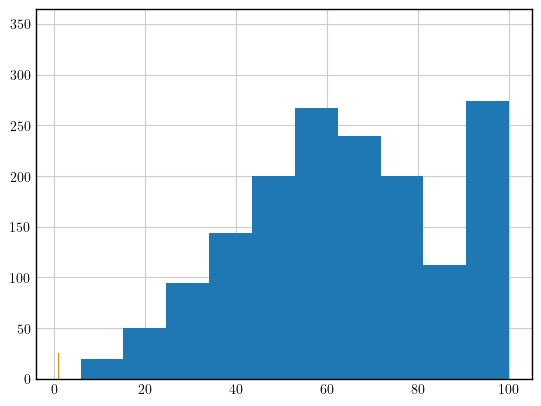

In [23]:
scores_preds.bleu_score.hist()
scores_preds.bert_f1.hist()

<Axes: >

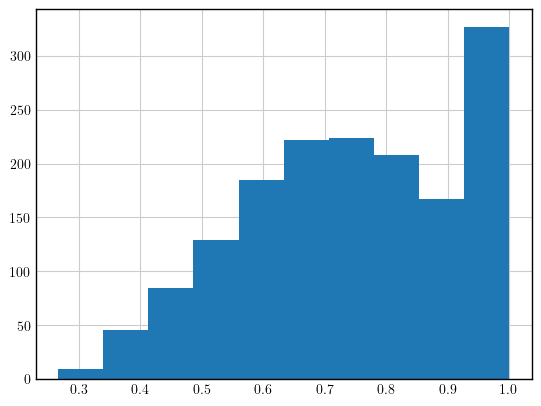

In [24]:
scores_preds.rouge_rougeL.hist()